In [1]:
import openmc
import numpy as np
from matplotlib import pyplot as plt

# OpenMC Materials

In this module we'll look at defining materials in OpenMC

Learning objectives:

- Defining material compositions with multiple approaches
- Plot material and nuclide cross sections

Materials are created using the `openmc.Material` class.

In [2]:
uo2 = openmc.Material()

As with `Surface`'s and `Cell`'s,  material IDs are automatically assigned if one isn't provided when the material is created. No nuclides have been added to the material and no density is set.

In [3]:
print(uo2)

Material
	ID             =	1
	Name           =	
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       



The `Material.add_nuclide` method can be used to update the material's composition. Nuclides and elements are referenced using the [GNDS](https://www.oecd-nea.org/jcms/pl_39689/specifications-for-the-generalised-nuclear-database-structure-gnds) format (i.e. `H1` and `H1`, respectively). Nuclide components of the material can be specified by either atom fraction (`'ao'`) or by weight fraction (`'wo'`).

Below is an example of a material with the following specification:

- Uranium oxide at 10 g/cm3 with the composition
    - U235 at 0.02115 weight %
    - U238 at 0.86032 weight %
    - O16 at 0.11852 weight %

In [4]:
uo2.add_nuclide('U235', 0.02115, 'wo')
uo2.add_nuclide('U238', 0.86032, 'wo')
uo2.add_nuclide('O16', 0.11852, 'wo')

In [5]:
print(uo2)

Material
	ID             =	1
	Name           =	
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U235           =	0.02115      [wo]
	U238           =	0.86032      [wo]
	O16            =	0.11852      [wo]



Material densites are specified with the `Material.set_density` method. Densities can be set with a variety of units. Densities can be set with any of the units specified below. 

```
The `sum` for density makes the assumption that all material nuclides are specified in units of `atom/b-cm`. Upon initialization for transport, OpenMC will sum the nuclide contributions to the material composition to represent the material density.
```

In [6]:
uo2.set_density('g/cc', 10.0)
help(uo2.set_density)

Help on method set_density in module openmc.material:

set_density(units: 'str', density: 'float | None' = None) method of openmc.material.Material instance
    Set the density of the material

    Parameters
    ----------
    units : {'g/cm3', 'g/cc', 'kg/m3', 'atom/b-cm', 'atom/cm3', 'sum', 'macro'}
        Physical units of density.
    density : float, optional
        Value of the density. Must be specified unless units is given as
        'sum'.



Nuclides can also be added to materials using the `Material.add_element` method, allowing one to specify a single element rather than a specific nuclide.

In [7]:
water = openmc.Material()
water.set_density('g/cc', 1.0)
water.add_element('H', 2.0)
water.add_element('O', 1.0)

In this case, OpenMC uses a combination of the natural abundancies of elements and the available set of nuclides in the [currrently configured nuclear data](https://docs.openmc.org/en/stable/usersguide/data.html#runtime-configuration) (i.e. the `openmc.config` object). The nuclear data is used to determine the nuclides to add and thier contributions to the material composition.

To reiterate, the set of nuclides added is influenced by the nuclear data _at the time of the call to `Material.add_element`.

In [8]:
print(water)

Material
	ID             =	2
	Name           =	
	Temperature    =	None
	Density        =	1.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	H1             =	1.99968852   [ao]
	H2             =	0.00031148   [ao]
	O16            =	0.999621     [ao]
	O17            =	0.000379     [ao]



# Thermal Information

## Material Temperatures

Material temperatures can be set by simply setting the `Material.temperature` attribute. **All temperatures set in OpenMC are in units of Kelvin.**

In [9]:
water.temperature = 600 # K

## Including Thermal Data

OpenMC datasets include $S(\alpha, \beta)$ information related to cross-sections for thermalized neutrons to account for the effects of thermal motion of atoms in the media through which they move. This information can be added using the `Material.add_s_alpha_beta` method.

In [10]:
help(water.add_s_alpha_beta)
water.add_s_alpha_beta('c_H_in_H20', 1.0)

Help on method add_s_alpha_beta in module openmc.material:

add_s_alpha_beta(name: 'str', fraction: 'float' = 1.0) method of openmc.material.Material instance
    Add an :math:`S(\alpha,\beta)` table to the material

    Parameters
    ----------
    name : str
        Name of the :math:`S(\alpha,\beta)` table
    fraction : float
        The fraction of relevant nuclei that are affected by the
        :math:`S(\alpha,\beta)` table.  For example, if the material is a
        block of carbon that is 60% graphite and 40% amorphous then add a
        graphite :math:`S(\alpha,\beta)` table with fraction=0.6.



## Other ways to add nuclides and generate materials

Materials can also be generated based on chemical formulae

In [11]:
water_again = openmc.Material(name="Water")
water_again.set_density('g/cc', 1.0)
water_again.add_elements_from_formula('H2O')
print(water_again)

Material
	ID             =	3
	Name           =	Water
	Temperature    =	None
	Density        =	1.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	H1             =	0.66656284   [ao]
	H2             =	0.00010382666666666666 [ao]
	O16            =	0.333207     [ao]
	O17            =	0.00012633333333333333 [ao]



Materials can also be mixed together to form new materials. Let's homogenize the water and fuel we've created together into a single material.

In [12]:
# from the PWR pincell model in the openmc.examples module
fuel_frac = 0.4572**2*np.pi / 1.26**2
water_frac = 1 - fuel_frac
mat_fracs = [fuel_frac, water_frac]
mats = [uo2, water_again]
pincell_mixture = openmc.Material.mix_materials(mats, mat_fracs)

In [13]:
print(pincell_mixture)

Material
	ID             =	4
	Name           =	(0.41363875844693687)-Water(0.5863612415530631)
	Temperature    =	None
	Density        =	5.625157025253727 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U235           =	0.003349020113401994 [ao]
	U238           =	0.13450759832848994 [ao]
	O16            =	0.47116181021921644 [ao]
	H1             =	0.39084661443553576 [ao]
	H2             =	6.08799331729827e-05 [ao]
	O17            =	7.407697018287032e-05 [ao]



## Modifying Material Compositions

Nuclides and elements can be removed from materials as well.

In [14]:
water.remove_nuclide('O16')
print(water)

Material
	ID             =	2
	Name           =	
	Temperature    =	600
	Density        =	1.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H20', 1.0)
	Nuclides       
	H1             =	1.99968852   [ao]
	H2             =	0.00031148   [ao]
	O17            =	0.000379     [ao]



In [15]:
water_again.remove_element('H')
print(water_again)

Material
	ID             =	3
	Name           =	Water
	Temperature    =	None
	Density        =	1.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	O16            =	0.333207     [ao]
	O17            =	0.00012633333333333333 [ao]



## Exporting Materials to XML

Materials can be collected into a group and exported to an XML file using the `Materials` object. 

In [16]:
materials = openmc.Materials([uo2, water])
materials.export_to_xml()

In [17]:
print(open('materials.xml', 'r').read())

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1">
    <density units="g/cc" value="10.0"/>
    <nuclide name="U235" wo="0.02115"/>
    <nuclide name="U238" wo="0.86032"/>
    <nuclide name="O16" wo="0.11852"/>
  </material>
  <material id="2" temperature="600">
    <density units="g/cc" value="1.0"/>
    <nuclide ao="1.99968852" name="H1"/>
    <nuclide ao="0.00031148" name="H2"/>
    <nuclide ao="0.000379" name="O17"/>
    <sab name="c_H_in_H20"/>
  </material>
</materials>



Materials can be imported from an XML file as well. This is true for the `Geometry`, `Settings`, `Tallies`, and `Plots` objects too. We'll see warnings here because the new `openmc.Material` objects have IDs that have been used in this Python session before.

In [18]:
xml_materials = openmc.Materials.from_xml()
print(xml_materials)

[Material
	ID             =	1
	Name           =	
	Temperature    =	None
	Density        =	10.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U235           =	0.02115      [wo]
	U238           =	0.86032      [wo]
	O16            =	0.11852      [wo]
, Material
	ID             =	2
	Name           =	
	Temperature    =	600.0
	Density        =	1.0 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H20', 1.0)
	Nuclides       
	H1             =	1.99968852   [ao]
	H2             =	0.00031148   [ao]
	O17            =	0.000379     [ao]
]


/cae-openmc-venv/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/cae-openmc-venv/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)


This object inherits from the built-in `list` type in Python and as a result the same operations can be performed on a `Materials` object as a `list`.

In [19]:
materials.append(water_again)

materials = openmc.Materials([uo2]) + [water]

water in materials

True

## Applying materials to geometry

Materials are used to fill cells in the OpenMC geometry

In [20]:
sphere = openmc.Sphere(r=10)
water_sphere = openmc.Cell(region=-sphere, fill=water)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

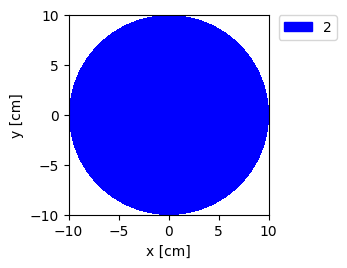

In [21]:
water_sphere.plot(color_by='material', colors={water: 'blue'}, legend=True)

## Plotting material and nuclide cross sections

The `openmc.plot_xs` function makes it relatively easy to plot the cross section of either materials or nuclides.

In [22]:
help(openmc.plot_xs)

Help on function plot_xs in module openmc.plotter:

plot_xs(reactions: 'Dict[str | openmc.Material, List[str]]', divisor_types: 'Iterable[str] | None' = None, temperature: 'float' = 294.0, axis: "'plt.Axes' | None" = None, sab_name: 'str | None' = None, ce_cross_sections: 'str | None' = None, mg_cross_sections: 'str | None' = None, enrichment: 'float | None' = None, plot_CE: 'bool' = True, orders: 'Iterable[int] | None' = None, divisor_orders: 'Iterable[int] | None' = None, energy_axis_units: 'str' = 'eV', **kwargs) -> "'plt.Figure' | None"
    Creates a figure of continuous-energy cross sections for this item.

    Parameters
    ----------
    reactions : dict
        keys can be either a nuclide or element in string form or an
        openmc.Material object. Values are a list of the types of
        cross sections to include in the plot.
    divisor_types : Iterable of values of PLOT_TYPES, optional
        Cross section types which will divide those produced by types
        before

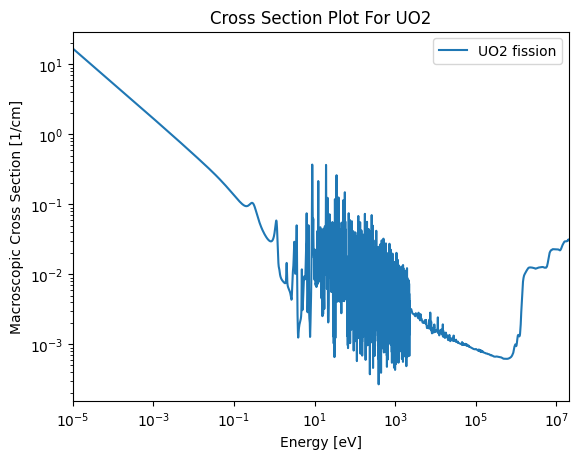

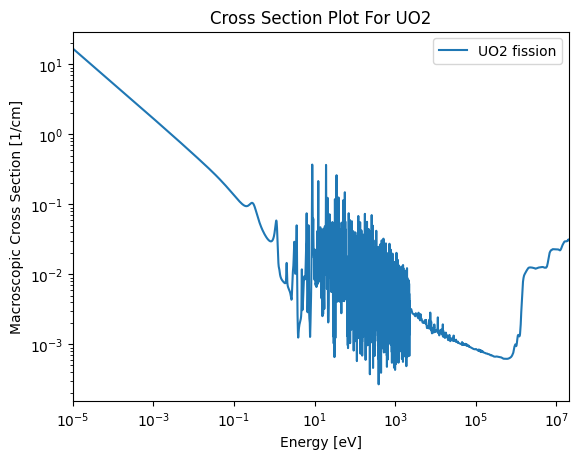

In [23]:
uo2.name = 'UO2'
openmc.plot_xs({uo2 : ['fission']})

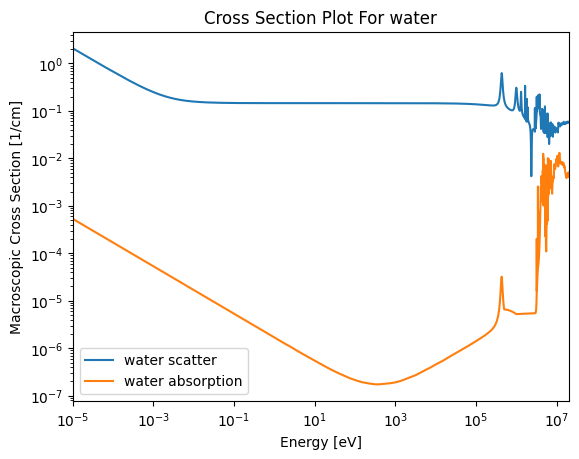

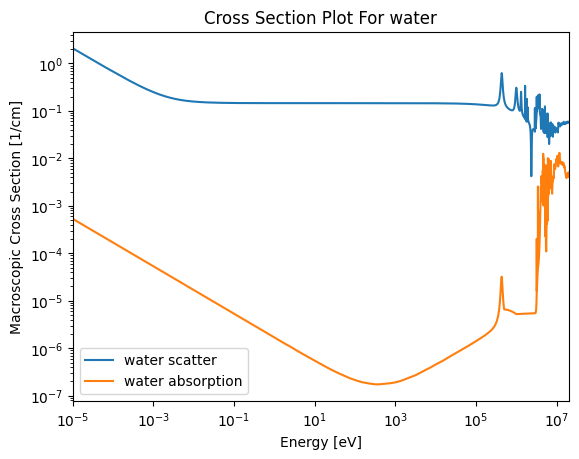

In [24]:
water_again.name = 'water'
openmc.plot_xs({water_again: ['scatter', 'absorption']})

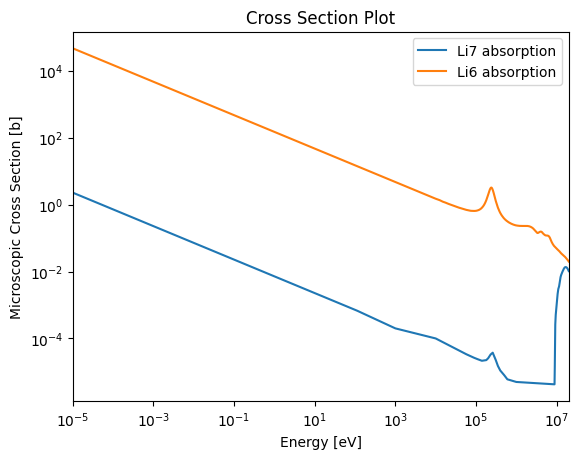

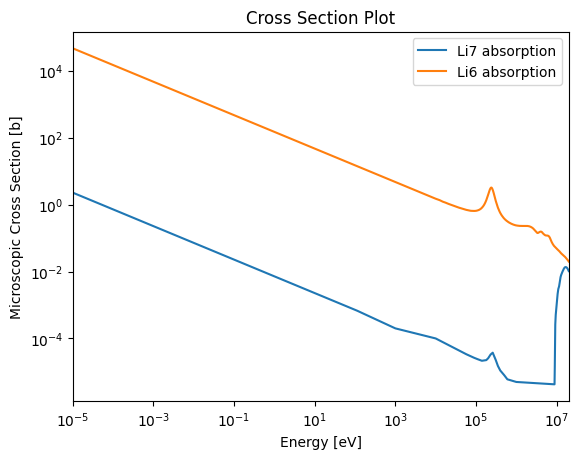

In [25]:
openmc.plot_xs({'Li7': ['absorption'], 'Li6': ['absorption']})

## Other `Material` attributes and features

There are other attributes of the `Material` that we'll discuss later:

  - `depletable` enables depletion of this material when using the `openmc.deplete` module
  - `volume` sets the volume of a material in the model (used in `openmc.deplete` and sometimes in tally normalization)
  - `get_activity` based on the volume, density, and composition, returns the activity or specific activity of the material
  - `get_decay_photon_energy` provides the energy distribution of a material with unstable isotopes